<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W4/ungraded_labs/C1_W4_Lab_1_image_generator_no_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training with ImageDataGenerator

In this lab, you will build a train a model on the [Horses or Humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans) dataset. This contains over a thousand images of horses and humans with varying poses and filesizes. You will use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class to prepare this dataset so it can be fed to a convolutional neural network.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

Run the code below to download the compressed dataset `horse-or-human.zip`.

In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

/bin/bash: /home/rgildin/miniconda3/envs/py310_keras_tensorflow/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2024-05-21 17:31:32--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.132.251, 142.251.129.155, 142.251.129.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.132.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  31.3MB/s    in 5.5s    

2024-05-21 17:31:38 (26.0 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



You can then unzip the archive using the [zipfile](https://docs.python.org/3/library/zipfile.html) module.

In [2]:
import zipfile

# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory `./horse-or-human`, which in turn each contain `horses` and `humans` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a horse looks like' and 'this is what a human looks like'.

One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans. You will use the ImageDataGenerator API instead -- and this is coded to automatically label images according to the directory names and structure. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. `ImageDataGenerator` will label the images appropriately for you, reducing a coding step. 

You can now define each of these directories:

In [3]:
import os

# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

Now see what the filenames look like in the `horses` and `humans` training directories:

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse08-0.png', 'horse48-3.png', 'horse21-5.png', 'horse09-6.png', 'horse47-4.png', 'horse16-1.png', 'horse49-8.png', 'horse36-7.png', 'horse48-8.png', 'horse04-5.png']
['human13-27.png', 'human08-25.png', 'human10-20.png', 'human03-06.png', 'human17-28.png', 'human07-28.png', 'human06-00.png', 'human04-20.png', 'human05-25.png', 'human04-16.png']


You can also find out the total number of horse and human images in the directories:

In [6]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Now take a look at a few pictures to get a better sense of what they look like. First, configure the `matplotlib` parameters:

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

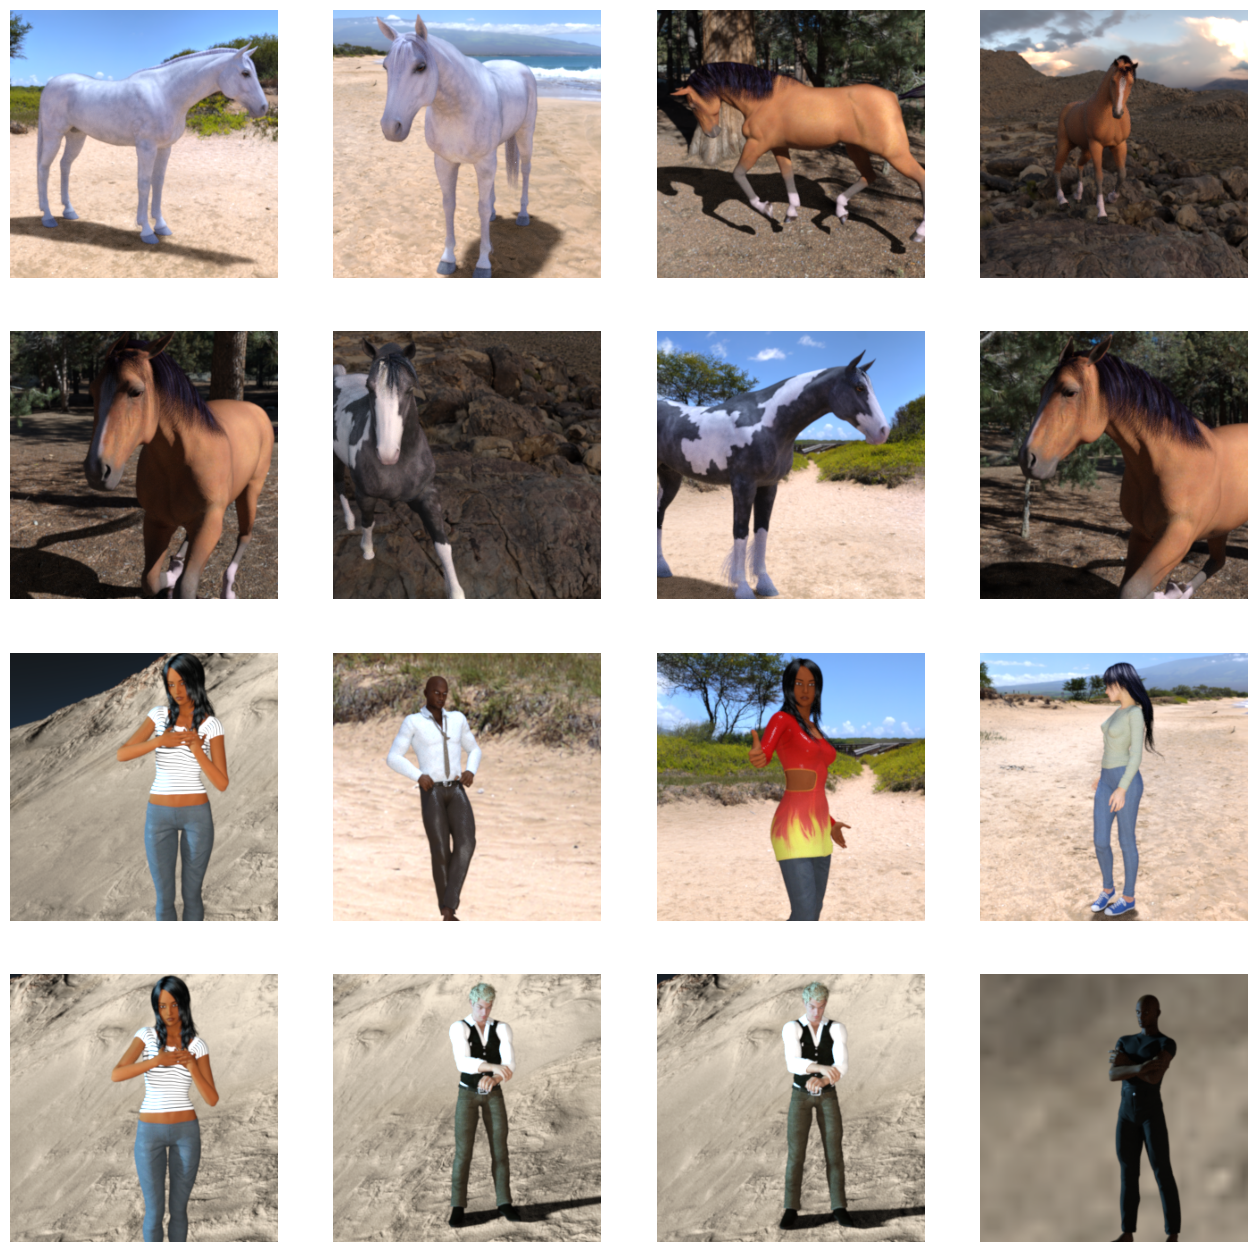

In [16]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

Now you can define the model architecture that you will train.

Step 1 will be to import tensorflow.

In [18]:
import tensorflow as tf

2024-05-21 17:38:10.274558: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 17:38:10.320669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 17:38:11.110546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


You then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers. Note that because this is a two-class classification problem, i.e. a *binary classification problem*, you will end your network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). This makes the output value of your network a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [19]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/home/rgildin/miniconda3/envs/py310_keras_tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-05-21 17:38:44.477325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:38:44.513632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:38:44.513715: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have 

You can review the network architecture and the output shapes with `model.summary()`.

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

The "output shape" column shows how the size of your feature map evolves in each successive layer. As you saw in an earlier lesson, the convolution layers removes the outermost pixels of the image, and each pooling layer halves the dimensions.

Next, you'll configure the specifications for model training. You will train the model with the [`binary_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss because it's a binary classification problem, and the final activation is a sigmoid. (For a refresher on loss metrics, see this [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) You will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, you will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [21]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 1027 images belonging to 2 classes.


### Training

You can start training for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses. 

In [25]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Epoch 1/15


/home/rgildin/miniconda3/envs/py310_keras_tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716324264.660750   10342 service.cc:145] XLA service 0x7f4244003a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716324264.660819   10342 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-05-21 17:44:24.699889: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-21 17:44:24.876124: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465]

1/8 ━━━━━━━━━━━━━━━━━━━━ 1:02 9s/step - accuracy: 0.3333 - loss: 0.6973

I0000 00:00:1716324267.678319   10342 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5161 - loss: 0.8158
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5469 - loss: 0.6803  
Epoch 3/15


2024-05-21 17:44:44.554316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-21 17:44:44.554399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-21 17:44:44.554417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3989127433879739791
2024-05-21 17:44:44.554462: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17179655389653727950
/home/rgildin/miniconda3/envs/py310_keras_tensorflow/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.5722 - loss: 0.6766
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6172 - loss: 0.6526  
Epoch 5/15


2024-05-21 17:44:50.669160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-21 17:44:50.669230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-21 17:44:50.669245: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3989127433879739791
2024-05-21 17:44:50.669291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17179655389653727950


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.5140 - loss: 0.7581
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7578 - loss: 0.6559  
Epoch 7/15


2024-05-21 17:44:57.162233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-21 17:44:57.162356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-21 17:44:57.162395: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3989127433879739791
2024-05-21 17:44:57.162452: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17179655389653727950


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.6715 - loss: 0.6664
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5156 - loss: 0.6796  
Epoch 9/15


2024-05-21 17:45:03.264015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-21 17:45:03.264067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-21 17:45:03.264076: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3989127433879739791
2024-05-21 17:45:03.264103: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17179655389653727950


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.7480 - loss: 0.5697
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.2359  
Epoch 11/15


2024-05-21 17:45:09.009867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-21 17:45:09.009907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-21 17:45:09.009915: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3989127433879739791
2024-05-21 17:45:09.009938: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17179655389653727950


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.7497 - loss: 1.0019
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9219 - loss: 0.1656  
Epoch 13/15


2024-05-21 17:45:14.919933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-21 17:45:14.920129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.8725 - loss: 0.3454
Epoch 14/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9531 - loss: 0.1572  
Epoch 15/15


2024-05-21 17:45:21.137455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-21 17:45:21.137513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-21 17:45:21.137527: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3989127433879739791
2024-05-21 17:45:21.137563: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17179655389653727950


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.9090 - loss: 0.2493


### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.7375239]
 is a human


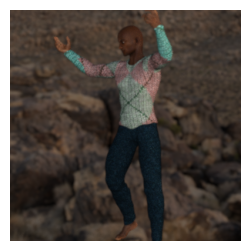

In [47]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(filepath, display_size=(3,3)):
    img = mpimg.imread(filepath)
    plt.figure(figsize=display_size)    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# predicting images
i = 600
path = train_generator.filepaths[i]
img = load_img(path, target_size=(300, 300))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])

if classes[0]>0.5: print(" is a human")
else: print(" is a horse")
display_image(path)


### Visualizing Intermediate Representations

To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


/tmp/ipykernel_9180/2477753207.py:45: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/tmp/ipykernel_9180/2477753207.py:48: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


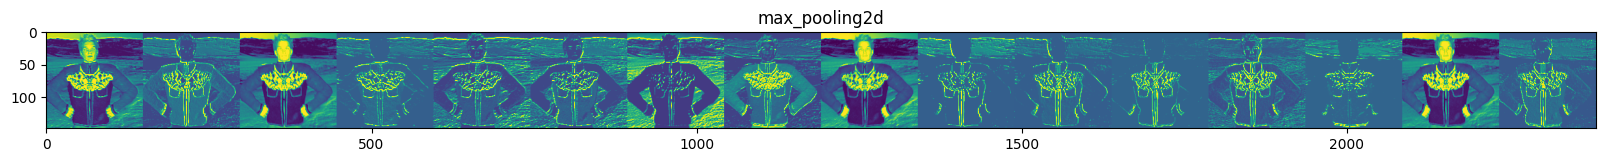

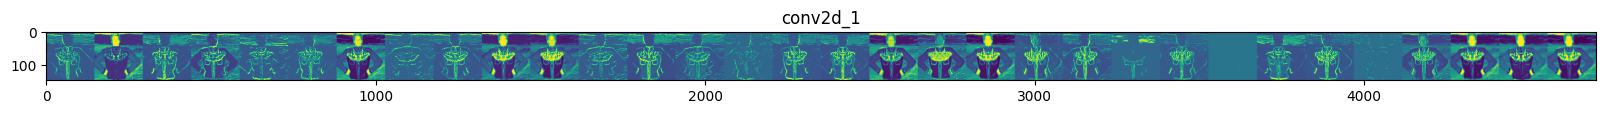

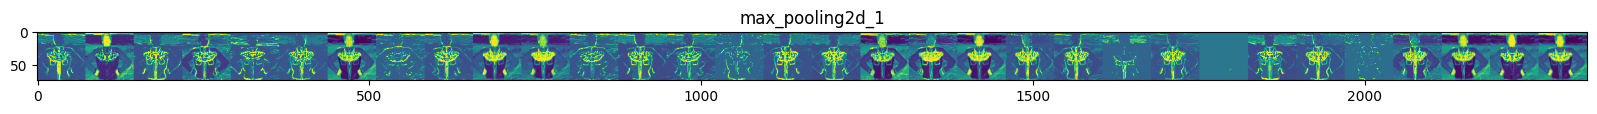

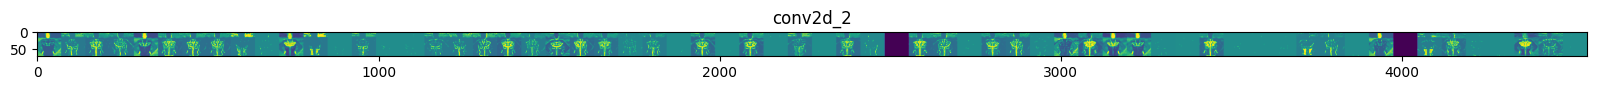

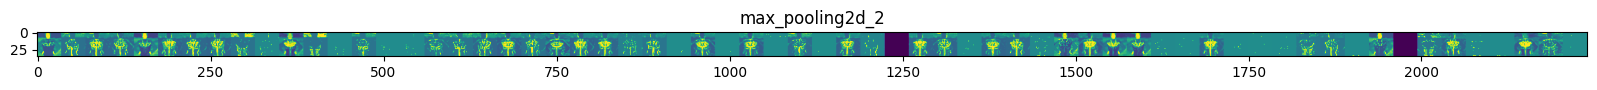

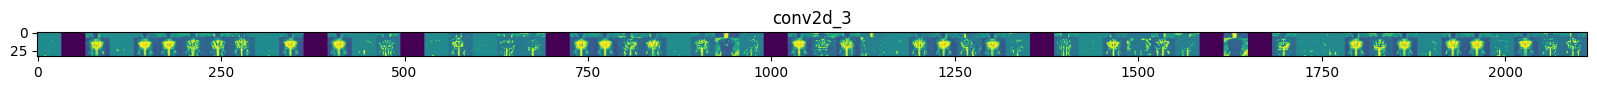

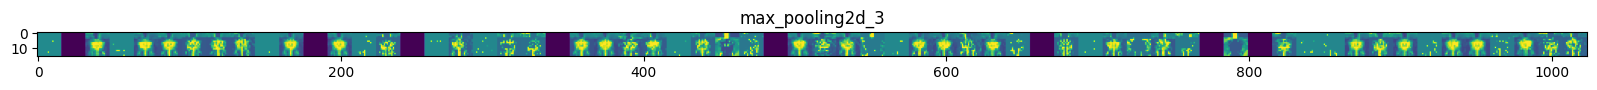

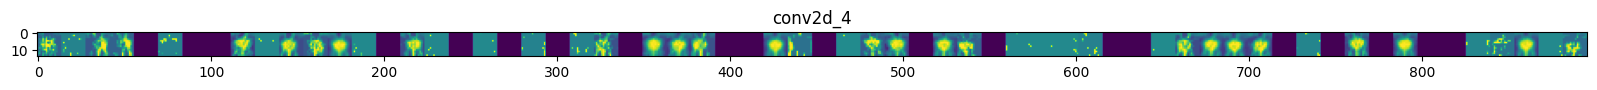

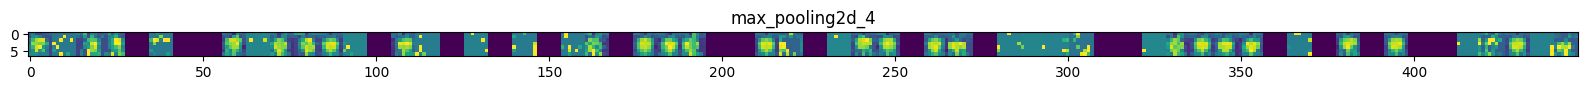

In [53]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid. 

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.